In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import SGDClassifier, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier
from dowhy import CausalModel

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

from typing import List

from sklearn.utils import resample

from econml.dr import DRLearner
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLasso
from econml.sklearn_extensions.model_selection import GridSearchCVList

from joblib import Parallel, delayed

Generating Synthetic Data

In [2]:
np.random.seed(42)

n = 50000

is_login = np.random.binomial(1, 0.3, size=n)
clicks = np.random.poisson(2, size=n)
is_open_profile = np.random.binomial(1, 0.3, size=n)
is_search = np.random.binomial(1, 0.4, size=n)
platform = np.random.choice([0, 1, 2], size=n)
lang = np.random.choice(["en", "es", "fr"], size=n)
clicks_notifications = np.random.exponential(scale=4, size=n)

# Adding linear relationships to treatment

treatment = is_open_profile * 0.3 + is_search * 0.6 + platform * 0.3 + is_login * 1.0 +\
    clicks * 1.2 + clicks_notifications * 0.1

treatment = (treatment > 4.5).astype(int)

added_ate = 0.12 # effect

# Adding linear relationships to a target metric

is_order = (treatment * 1.0 + is_login * 3.7 + clicks * 0.05 + clicks_notifications * 0.2 +\
    1.2 * platform + np.random.normal(0, 0.001, n) + (treatment * added_ate)) > 4.9

df = pd.DataFrame({
    "is_order": is_order.astype(int), # Y
    "treatment": treatment, # T
    "is_login": is_login, # Potential Confounder
    "clicks": clicks, # Potential Confounder
    "clicks_notifications": clicks_notifications, # Potential Confounder
    "is_open_profile": is_open_profile, # Potential Potential Confounder
    "is_search": is_search, # Potential Confounder
    "platform": platform, # Potential Confounder
    "lang": lang # Potential Confounder
})

df["user_id"] = np.arange(1, len(df) + 1)

df.head()


,is_order,treatment,is_login,clicks,clicks_notifications,is_open_profile,is_search,platform,lang,user_id
0,0,0,0,2,3.740028,0,1,2,en,1
1,1,1,1,3,6.105136,0,0,0,fr,2
2,0,0,1,2,2.268096,0,1,0,es,3
3,0,1,0,4,0.342768,0,1,2,en,4
4,0,0,0,3,4.401981,0,0,0,fr,5


In [3]:
df[[
    "is_order",
    "treatment",
    "is_login",
    "clicks",
    "clicks_notifications",
    "is_open_profile", 
    "is_search",
    "platform"

]].corr()

,is_order,treatment,is_login,clicks,clicks_notifications,is_open_profile,is_search,platform
is_order,1.000000,0.352531,0.793841,0.120065,0.227152,0.011176,0.017554,0.197721
treatment,0.352531,1.000000,0.187712,0.738316,0.171341,0.054442,0.126213,0.094889
is_login,0.793841,0.187712,1.000000,0.007043,-0.004619,0.002950,0.001561,-0.007268
clicks,0.120065,0.738316,0.007043,1.000000,-0.000874,-0.000215,-0.000224,0.006619
clicks_notifications,0.227152,0.171341,-0.004619,-0.000874,1.000000,0.002300,0.004561,-0.001348
is_open_profile,0.011176,0.054442,0.002950,-0.000215,0.002300,1.000000,-0.005675,-0.004867
is_search,0.017554,0.126213,0.001561,-0.000224,0.004561,-0.005675,1.000000,-0.006274
platform,0.197721,0.094889,-0.007268,0.006619,-0.001348,-0.004867,-0.006274,1.000000


In [4]:
df.groupby(["treatment"]).agg({"is_order": "mean", "user_id": "count"}).reset_index()

,treatment,is_order,user_id
0,0,0.175311,34356
1,1,0.517579,15644


In [5]:
smf.ols("is_order ~ treatment", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1753,0.002,77.134,0.000,0.171,0.180
treatment,0.3423,0.004,84.235,0.000,0.334,0.350


The resulting absolute effect is ~0.3423

But this effect is biased by the initial feature bias in the data. Let's have this value of ate as a base

Next, we will calculate the correlations of the target variable `is_order` with each of the features, as well as the correlation of the fact of treatment with each of the features. This will be necessary for the selection of features-confounders

### Correlations

In [6]:
df_corr = df.copy()

df_corr["lang"] = df_corr["lang"].astype("category")
cat_columns = df_corr.select_dtypes(["category"]).columns
df_corr[cat_columns] = df_corr[cat_columns].apply(lambda x: x.cat.codes)

mx = df_corr.phik_matrix()

interval columns not set, guessing: ['is_order', 'treatment', 'is_login', 'clicks', 'clicks_notifications', 'is_open_profile', 'is_search', 'platform', 'lang', 'user_id']


In [7]:
mx[["is_order"]].sort_values(by=["is_order"], ascending=False).head(10).T

,is_order,is_login,treatment,clicks_notifications,clicks,platform,is_search,is_open_profile,user_id,lang
is_order,1.0,0.947996,0.525787,0.297416,0.172211,0.123586,0.026587,0.016005,0.006262,0.003842


In [8]:
mx[["treatment"]].sort_values(by=["treatment"], ascending=False).head(10).T

,treatment,clicks,is_order,is_login,clicks_notifications,is_search,is_open_profile,platform,lang,user_id
treatment,1.0,0.94663,0.525787,0.290456,0.209628,0.196772,0.085051,0.05708,0.004376,0.0


We observe that the variable `is_login` is strongly related to the target metric `is_order`, while this variable is also related to the treatment. This means that we can include this variable as a confounder

The same applies to variables `clicks_notifications` and `platform`. Although the variable `platform` is not strongly related to the treatment, it is strongly related to the target metric. Therefore, we include it in the calculations as a confounder.

The variables `is_search`, `is_open_profile` and `lang` are not strongly related to the treatment or the target metric.

And the variable `clicks` is very strongly related to the treatment, but weakly related to the target metric `is_order`. We will not include this variable as a confounder precisely because it is very strongly related to the treatment. It will be a strong predictor of the treatment, which will not allow us to build a good model for obtaining propensity scores.

### Linear model propensity scores

Building a linear model to obtain the proficiency score using the selected confounders

In [9]:
df_ = df[[
    "user_id",
    "is_order",
    "treatment",
    "is_login",
    "clicks_notifications",
    "platform",
#     "clicks",
]]

In [10]:
def get_lr_model(
    df: pd.DataFrame,
    cat_features: List[str],
    num_features: List[str],
    
    features: List[str],
    n_components_pca: float = 0.8,
    
):
    """"""
    
    categorical_features = cat_features

    numeric_features = num_features

    X = df_[features]

    y = df_["treatment"]

    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
            ("num", numeric_transformer, numeric_features)
        ])

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=n_components_pca)),
        ("classifier", LogisticRegression(
            C=0.1,
            penalty="l2",
            class_weight="balanced",
            random_state=42
        ))
    ])

    model.fit(X, y)
    
    return model


In [11]:
model = get_lr_model(
    df_,
    [],
    ["is_login","clicks_notifications", "platform"],
    ["is_login","clicks_notifications", "platform"],
)

In [12]:
X = df_[["is_login","clicks_notifications", "platform"]]

y = df_["treatment"]

In [13]:
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.63218


In [14]:
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

Precision: 0.43309464659749625
Recall: 0.5683329071848632
F1-Score: 0.4915821192602218


In [15]:
roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.6584455418871498


Judging by the obtained metrics, the model is quite adequate.

We will get the propensity scores

In [16]:
data_ps = df_.assign(propensity_score=model.predict_proba(X)[:, 1])

In [17]:
def draw_distribution_ps_plot(
    data_ps: pd.DataFrame,
    type_of_plot: str,
    col_treat: str = "treatment",
    col_ps: str = "propensity_score"
) -> None:
    """"""
    
    scores_experimental = data_ps[data_ps[col_treat] == 1][col_ps]
    scores_control = data_ps[data_ps[col_treat] == 0][col_ps]

    plt.figure(figsize=(10, 6), dpi=180)
    
    if type_of_plot == "kde":
        sns.kdeplot(scores_experimental, label="Treatment group", color="red", fill=True)
        sns.kdeplot(scores_control, label="Control group", color="blue", fill=True)
    elif type_of_plot == "hist":
        sns.histplot(scores_experimental, label="Treatment group", color="red")
        sns.histplot(scores_control, label="Control group", color="blue")
        
    plt.title("Distribution Propensity Scores by groups")
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    return


Let's look at the distribution of propensity scores between groups

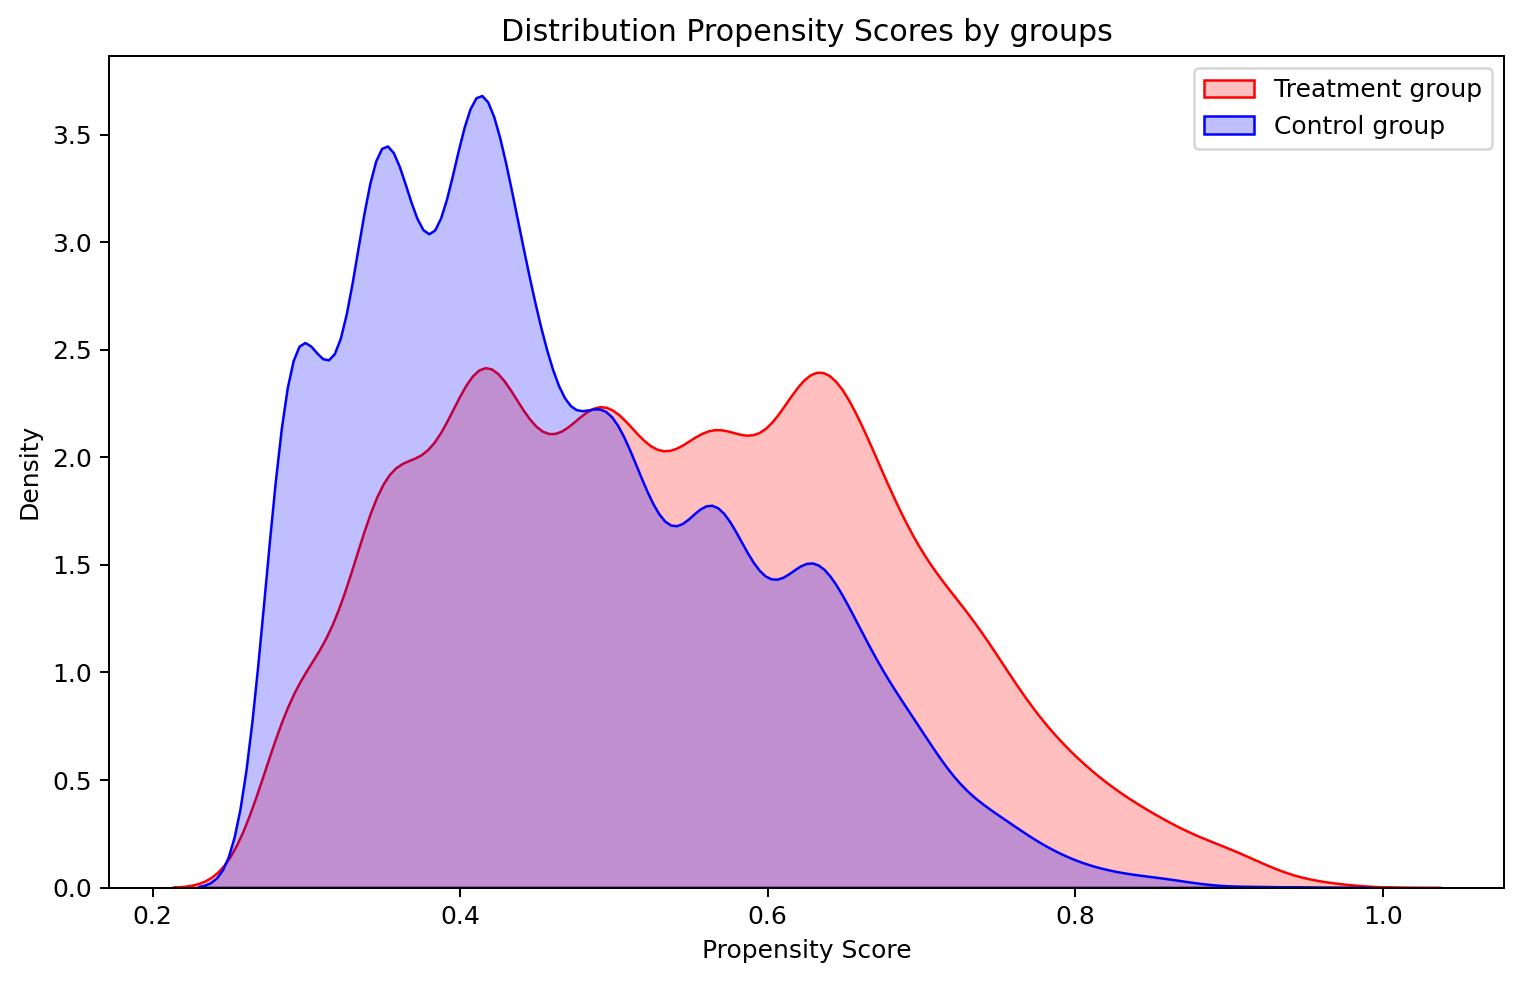

In [18]:
draw_distribution_ps_plot(data_ps, "kde")

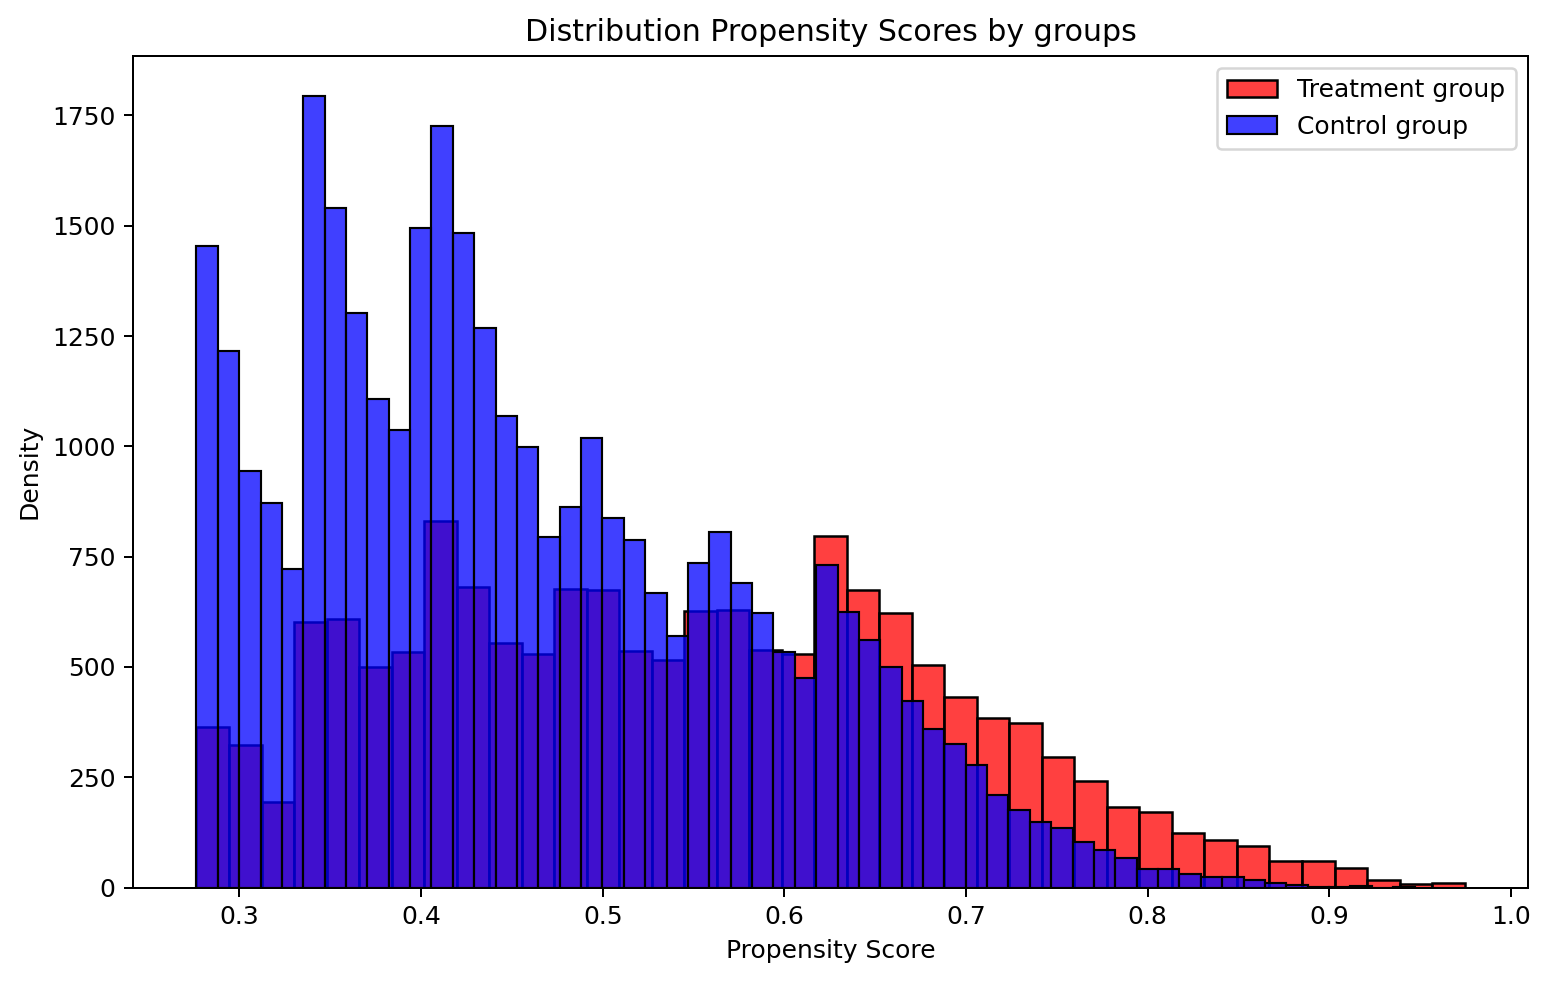

In [19]:
draw_distribution_ps_plot(data_ps, "hist")

We see that the propensity scores overlap well between the groups. But on the right there is a small tail of users in the treatment group for whom there are no users from the control group with similar scores.

Therefore, it makes sense to further cut off the sample on the right by the value 0.7, for example (looking at the histogram). But we must take this fact into account when we interpret the result obtained

In [20]:
# data_ps[data_ps["propensity_score"] > 0]
data_ps = data_ps[data_ps["propensity_score"] < 0.7]

Let's check the distribution of the number of users between groups

In [21]:
data_ps.groupby(["treatment"]).agg({"user_id": "nunique"}).reset_index()

,treatment,user_id
0,0,32957
1,1,13340


### Сomplex model propensity scores

In [22]:
X = df_.drop(["user_id", "treatment", "is_order"], axis=1)
y = df_["treatment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.01,
    depth=5,
    eval_metric="F1",
    use_best_model=True,
    random_seed=42,
    verbose=300,
    auto_class_weights="Balanced"
)

In [24]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6057821	test: 0.6053420	best: 0.6053420 (0)	total: 73.9ms	remaining: 14.7s
199:	learn: 0.5996647	test: 0.6075784	best: 0.6123273 (2)	total: 910ms	remaining: 0us

bestTest = 0.6123272865
bestIteration = 2

Shrink model to first 3 iterations.


In [25]:
df_ = df_.copy()
df_["propensity_score"] = model.predict_proba(X)[:, 1]


In [26]:
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.61858


In [27]:
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

Precision: 0.4231028138042454
Recall: 0.6026591664535924
F1-Score: 0.4971656076146282


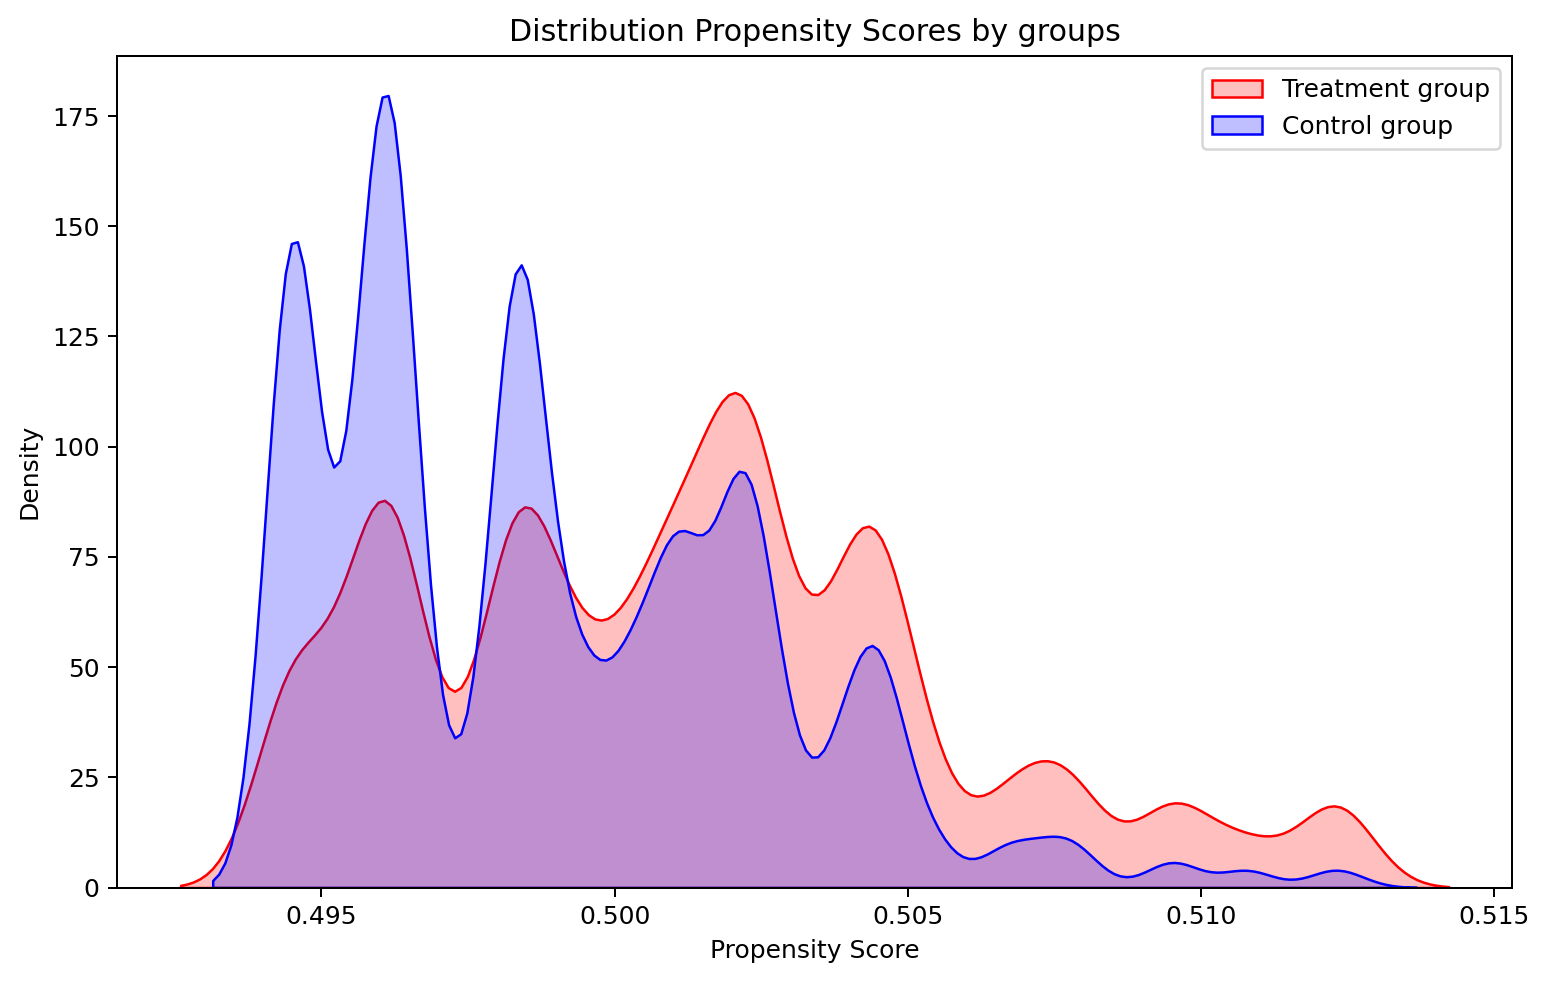

In [28]:
draw_distribution_ps_plot(df_, "kde")

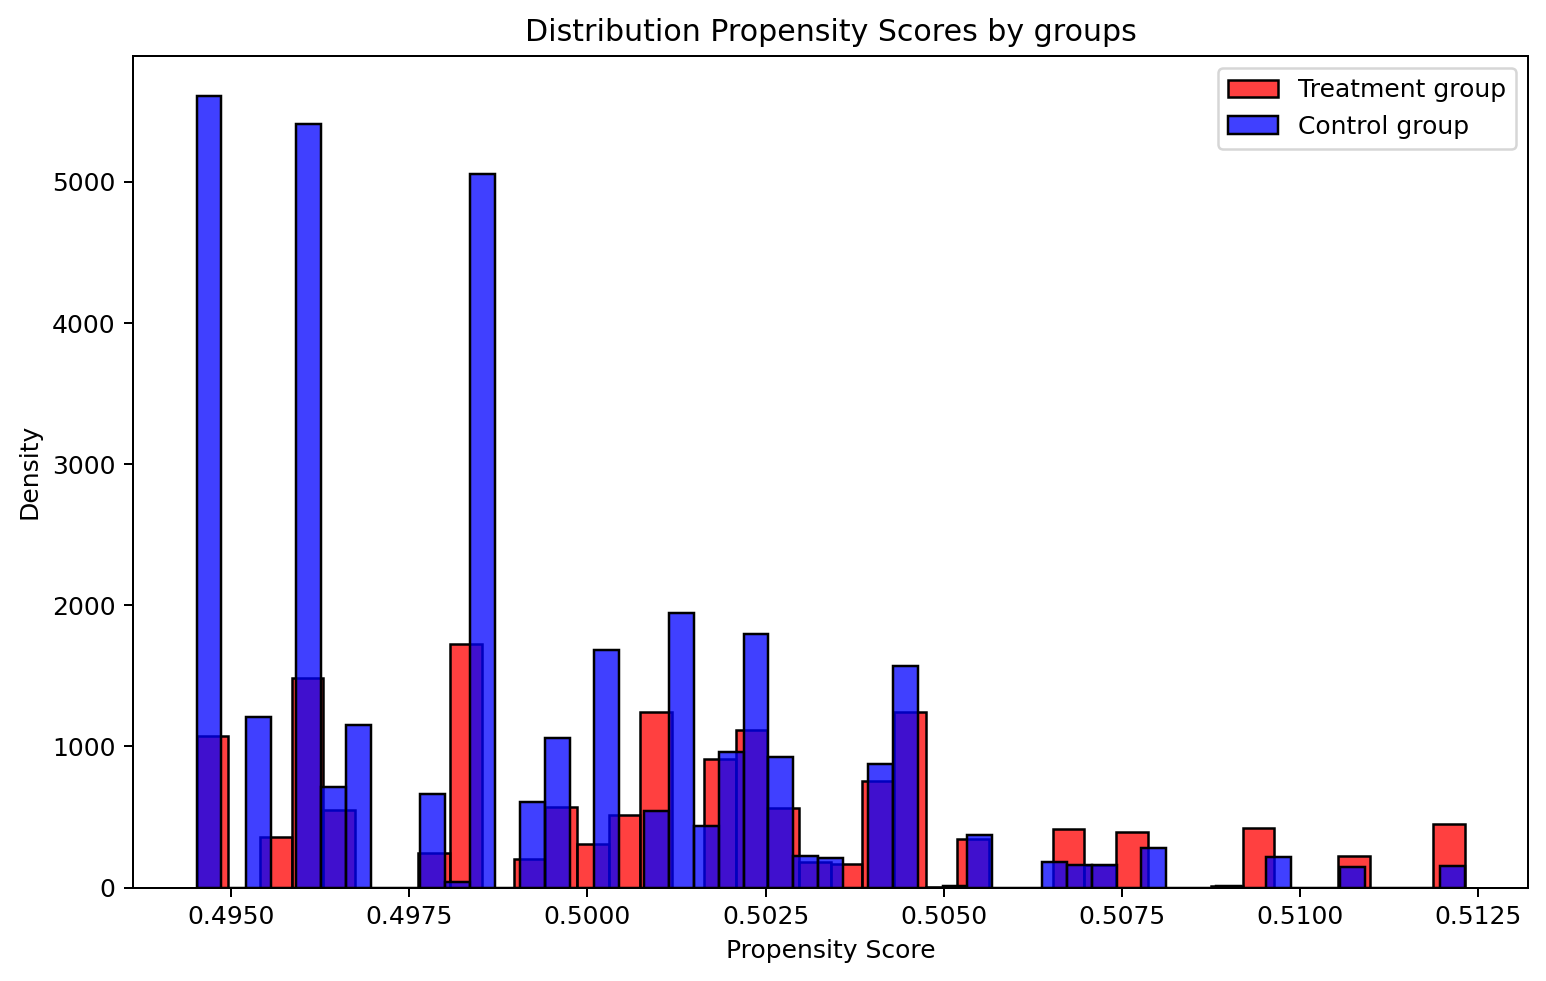

In [29]:
draw_distribution_ps_plot(df_, "hist")

### PSW

In [30]:
def get_ate_psw(data_ps: pd.DataFrame, col_treat: str, col_ps: str, col_target: str):
    """"""
    
    weights = data_ps[col_treat] / data_ps[col_ps] + \
        (1 - data_ps[col_treat]) / (1 - data_ps[col_ps]) # Weights for PSW

    data_ps["weights"] = weights

    # weighted mean of outcome for treatment group
    weighted_avg_outcome_treatment = (data_ps[data_ps[col_treat] == 1][col_target] * \
        data_ps[data_ps[col_treat] == 1]["weights"]).sum() / data_ps[data_ps[col_treat] == 1]["weights"].sum()

    # for control group
    weighted_avg_outcome_control = (data_ps[data_ps[col_treat] == 0][col_target] * \
        data_ps[data_ps[col_treat] == 0]["weights"]).sum() / data_ps[data_ps[col_treat] == 0]["weights"].sum()

    # average treatment effect
    weighted_effect = weighted_avg_outcome_treatment - weighted_avg_outcome_control
    
    return weighted_effect


PSW from linear model

In [31]:
weighted_effect = get_ate_psw(
    data_ps,
    "treatment",
    "propensity_score",
    "is_order"
)

print(f"ATE obtained by the PSW method for a linear model: {round(weighted_effect, 2)}")


ATE obtained by the PSW method for a linear model: 0.14


In [32]:
weighted_effect = get_ate_psw(
    df_,
    "treatment",
    "propensity_score",
    "is_order"
)

print(f"ATE obtained by the PSW method for a catboost model: {round(weighted_effect, 2)}")


ATE obtained by the PSW method for a catboost model: 0.34


We can see that the linear model gives the closest estimate to the real one.

Let's check the balance of covariates for each of the models

We can use SMD (Standardized Mean Difference)

Check SMD for linear model PSW

In [33]:
def weighted_mean(x, w):
    """"""
    return np.sum(x * w) / np.sum(w)

def weighted_std(x, w):
    """"""
    mean = weighted_mean(x, w)
    
    return np.sqrt(np.sum(w * (x - mean) ** 2) / np.sum(w))

def smd(x_treat, x_control, w_treat, w_control):
    """"""
    mean_treat = weighted_mean(x_treat, w_treat)
    mean_control = weighted_mean(x_control, w_control)
    sd_pooled = np.sqrt((weighted_std(x_treat, w_treat) ** 2 + weighted_std(x_control, w_control) ** 2) / 2)
    
    return (mean_treat - mean_control) / sd_pooled


def get_smd_value(data_ps: pd.DataFrame, covariate: str, col_treat: str):
    """"""
    treatment = data_ps[col_treat]
    weights = data_ps["weights"]
    covariate1 = data_ps["is_login"]
    
    x_treat_cov1 = data_ps.loc[data_ps[col_treat] == 1, covariate]
    x_control_cov1 = data_ps.loc[data_ps[col_treat] == 0, covariate]
    w_treat = data_ps.loc[data_ps[col_treat] == 1, "weights"]
    w_control = data_ps.loc[data_ps[col_treat] == 0, "weights"]
    
    smd_cov = smd(x_treat_cov1, x_control_cov1, w_treat, w_control)

    return smd_cov


In [34]:
print(f"SMD for is_login: {get_smd_value(data_ps, 'is_login', 'treatment')}")

SMD for is_login: -0.013657924723841933


In [35]:
print(f"SMD for is_login: {get_smd_value(data_ps, 'clicks_notifications', 'treatment')}")

SMD for is_login: -0.015413081591677683


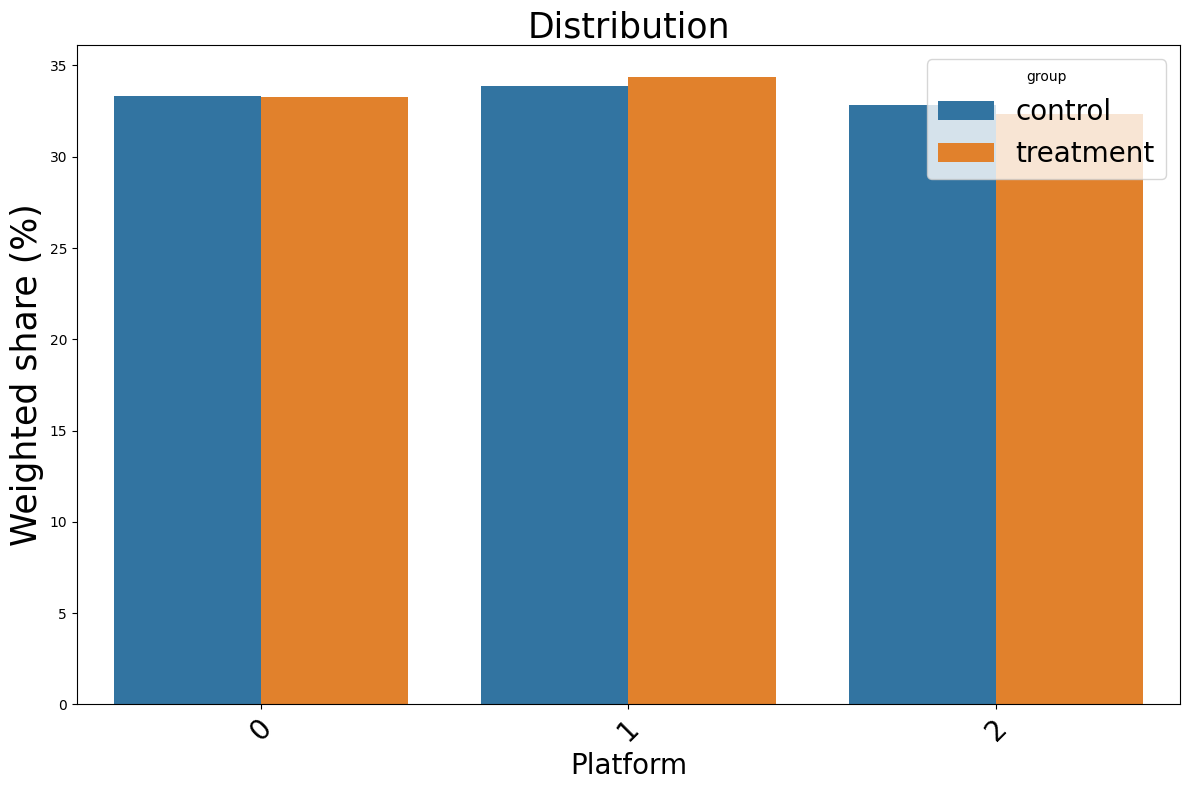

In [36]:
category_distribution = data_ps.groupby(["treatment", "platform"]).apply(
    lambda x: np.sum(x["weights"]) / np.sum(data_ps["weights"][data_ps["treatment"] == x["treatment"].iloc[0]])
).reset_index(name="weighted_proportion")

category_distribution["weighted_proportion"] *= 100

plt.figure(figsize=(12, 8))
sns.barplot(x="platform", y="weighted_proportion", hue="treatment", data=category_distribution)

plt.title("Distribution", size=25)
plt.ylabel("Weighted share (%)", size=25)
plt.xticks(rotation=45, fontsize=20)
plt.xlabel("Platform", fontsize=20)
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, title="group", labels=["control", "treatment"], fontsize=20)
plt.tight_layout()
plt.show()

Check SMD for catboost model PSW

In [37]:
print(f"SMD for is_login: {get_smd_value(df_, 'is_login', 'treatment')}")

SMD for is_login: 0.3887216358566662


In [38]:
print(f"SMD for is_login: {get_smd_value(df_, 'clicks_notifications', 'treatment')}")

SMD for is_login: 0.34444728644855643


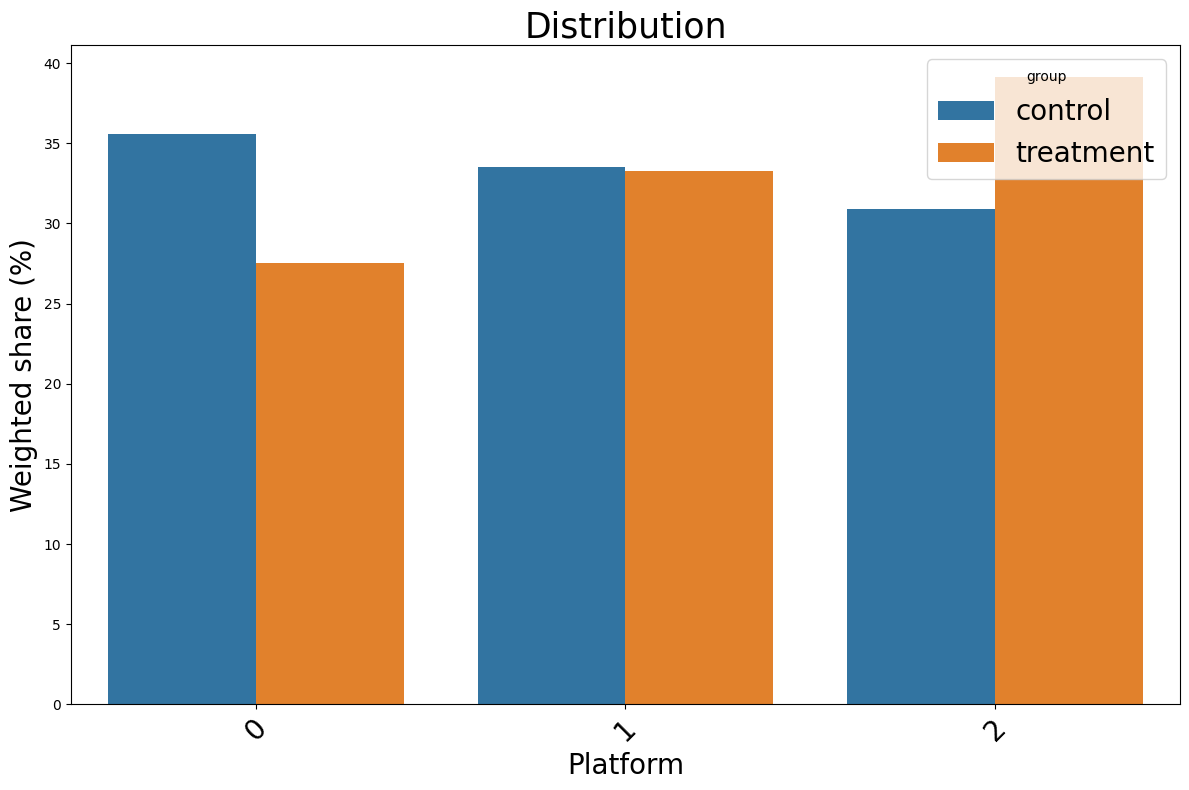

In [39]:
category_distribution = df_.groupby(["treatment", "platform"]).apply(
    lambda x: np.sum(x["weights"]) / np.sum(df_["weights"][df_["treatment"] == x["treatment"].iloc[0]])
).reset_index(name="weighted_proportion")

category_distribution["weighted_proportion"] *= 100

plt.figure(figsize=(12, 8))
sns.barplot(x="platform", y="weighted_proportion", hue="treatment", data=category_distribution)

plt.title("Distribution", size=25)
plt.ylabel("Weighted share (%)", size=20)
plt.xticks(rotation=45, fontsize=20)
plt.xlabel("Platform", fontsize=20)
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, title="group", labels=["control", "treatment"], fontsize=20)
plt.tight_layout()
plt.show()

We see that the balance of covariates after applying the simple model to obtain the propensity scores is good. While the balance of covariates after applying the complex model is bad: we observe an imbalance across all confounders

This is why we can trust the estimate obtained from a logistic regression model and cannot trust the estimate obtained from a more complex model.

#### PSW from DoWhy

In [40]:
model = CausalModel(
  data=df_,
  treatment="treatment",
  outcome="is_order",
  common_causes=["is_login", "platform", "clicks_notifications"]
)

identified_estimand = model.identify_effect()

causal_effect_psw = model.estimate_effect(identified_estimand,
                                          method_name="backdoor.propensity_score_weighting")
print(causal_effect_psw)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                          
────────────(E[is_order|is_login,clicks_notifications,platform])
d[treatment]                                                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→is_order then P(is_order|treatment,is_login,clicks_notifications,platform,U) = P(is_order|treatment,is_login,clicks_notifications,platform)

## Realized estimand
b: is_order~treatment+is_login+clicks_notifications+platform
Target units: ate

## Estimate
Mean value: 0.3368065446936664



Next we will apply the PSM method

### PSM

#### PS from logistic regression

In [41]:
treated = data_ps[data_ps["treatment"] == 1]
control = data_ps[data_ps["treatment"] == 0]

In [42]:
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")

In [43]:
nn.fit(control[["propensity_score"]])

NearestNeighbors(metric='euclidean', n_neighbors=1)

In [44]:
distances, indices = nn.kneighbors(treated[["propensity_score"]])

In [45]:
matched_indices = indices.reshape(-1)
matched_control_df = control.iloc[matched_indices].reset_index(drop=True)
matched_treated_df = treated.reset_index(drop=True)

In [46]:
effect = matched_treated_df["is_order"].mean() - matched_control_df["is_order"].mean()
print(f"ATE obtained by the PSM method for a logistic regression model: {round(effect, 2)}")

ATE obtained by the PSM method for a logistic regression model: 0.18


Let's check the balance of covariates after applying the PSM method

In [47]:
df_matched = pd.concat([matched_control_df, matched_treated_df])

In [48]:
# before psm
stat, p_value = ttest_ind(
    df_[df_["treatment"] == 0]["is_login"],
    df_[df_["treatment"] == 1]["is_login"]
)
print(f"Before PSM, p-value: {p_value}")

# after psm
stat, p_value = ttest_ind(
    df_matched[df_matched["treatment"] == 0]["is_login"],
    df_matched[df_matched["treatment"] == 1]["is_login"])
print(f"After PSM, p-value: {p_value}")


Before PSM, p-value: 0.0
After PSM, p-value: 0.21765449318374763


In [49]:
covariates = [    
    "is_login",
    "clicks_notifications",
]

In [50]:
balanced_pvalue = list()
before_pvalue = list()

for cov in covariates:
    stat, p_value = ttest_ind(
        df_[df_["treatment"] == 0][cov],
        df_[df_["treatment"] == 1][cov]
    )
    
    before_pvalue.append(p_value)
    
    stat, p_value = ttest_ind(
        df_matched[df_matched["treatment"] == 0][cov],
        df_matched[df_matched["treatment"] == 1][cov]
    )
    
    balanced_pvalue.append(p_value)

print(balanced_pvalue)

[0.21765449318374763, 0.4379486295071445]


Let's calculate the confidence interval for the effect

In [51]:
n_bootstraps = 3000
bootstrap_estimates = []

for _ in tqdm(range(n_bootstraps)):
    boot_treated = resample(matched_treated_df, replace=True, n_samples=len(matched_treated_df))
    boot_control = resample(matched_control_df, replace=True, n_samples=len(matched_control_df))
    
    boot_effect = boot_treated["is_order"].mean() - boot_control["is_order"].mean()
    bootstrap_estimates.append(boot_effect)

lower_bound = np.percentile(bootstrap_estimates, 2.5)
upper_bound = np.percentile(bootstrap_estimates, 97.5)

print(f"PSM 95% CI for effect: ({lower_bound}, {upper_bound})")

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1941.66it/s]

PSM 95% CI for effect: (0.1670914542728636, 0.1895052473763118)


#### PS from catboost model

In [52]:
treated = df_[df_["treatment"] == 1]
control = df_[df_["treatment"] == 0]

In [53]:
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")

In [54]:
nn.fit(control[["propensity_score"]])

NearestNeighbors(metric='euclidean', n_neighbors=1)

In [55]:
distances, indices = nn.kneighbors(treated[["propensity_score"]])

In [56]:
matched_indices = indices.reshape(-1)
matched_control_df = control.iloc[matched_indices].reset_index(drop=True)
matched_treated_df = treated.reset_index(drop=True)

In [57]:
effect = matched_treated_df["is_order"].mean() - matched_control_df["is_order"].mean()
print(f"ATE obtained by the PSM method for a catboost model: {round(effect, 2)}")

ATE obtained by the PSM method for a catboost model: 0.18


Let's check the balance of covariates after applying the PSM method

In [58]:
df_matched = pd.concat([matched_control_df, matched_treated_df])

In [59]:
from scipy.stats import ttest_ind

# before psm
stat, p_value = ttest_ind(
    df_[df_["treatment"] == 0]["is_login"],
    df_[df_["treatment"] == 1]["is_login"]
)
print(f"Before PSM, p-value: {p_value}")

# after psm
stat, p_value = ttest_ind(
    df_matched[df_matched["treatment"] == 0]["is_login"],
    df_matched[df_matched["treatment"] == 1]["is_login"])
print(f"After PSM, p-value: {p_value}")


Before PSM, p-value: 0.0
After PSM, p-value: 1.0


In [60]:
covariates = [    
    "is_login",
    "clicks_notifications",
]

In [61]:
balanced_pvalue = list()
before_pvalue = list()

for cov in covariates:
    stat, p_value = ttest_ind(
        df_[df_["treatment"] == 0][cov],
        df_[df_["treatment"] == 1][cov]
    )
    
    before_pvalue.append(p_value)
    
    stat, p_value = ttest_ind(
        df_matched[df_matched["treatment"] == 0][cov],
        df_matched[df_matched["treatment"] == 1][cov]
    )
    
    balanced_pvalue.append(p_value)

print(balanced_pvalue)

[1.0, 5.543710149591568e-30]


In [62]:
n_bootstraps = 3000
bootstrap_estimates = []

for _ in tqdm(range(n_bootstraps)):
    boot_treated = resample(matched_treated_df, replace=True, n_samples=len(matched_treated_df))
    boot_control = resample(matched_control_df, replace=True, n_samples=len(matched_control_df))
    
    boot_effect = boot_treated["is_order"].mean() - boot_control["is_order"].mean()
    bootstrap_estimates.append(boot_effect)

lower_bound = np.percentile(bootstrap_estimates, 2.5)
upper_bound = np.percentile(bootstrap_estimates, 97.5)

print(f"PSM 95% CI for effect: ({lower_bound}, {upper_bound})")

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1158.60it/s]

PSM 95% CI for effect: (0.17156577601636408, 0.19298293275377143)


We see that the method using the logistic regression model balances the confounders better, although the more complex model did a good job in this case. And once we get well-balanced confounders, the result becomes close to the correct one.

#### PSM from DoWhy

In [63]:
model = CausalModel(
  data=df_,
  treatment="treatment",
  outcome="is_order",
  common_causes=["is_login", "platform", "clicks_notifications"]
)

identified_estimand = model.identify_effect()

causal_effect_psw = model.estimate_effect(identified_estimand,
                                          method_name="backdoor.propensity_score_matching")
print(causal_effect_psw)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                          
────────────(E[is_order|is_login,clicks_notifications,platform])
d[treatment]                                                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→is_order then P(is_order|treatment,is_login,clicks_notifications,platform,U) = P(is_order|treatment,is_login,clicks_notifications,platform)

## Realized estimand
b: is_order~treatment+is_login+clicks_notifications+platform
Target units: ate

## Estimate
Mean value: 0.15082



### Doubly Robust

In [64]:
categorical_features = []

numeric_features = [
    "is_login",
    "platform",
    "clicks_notifications",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ])


ps_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(penalty="l2", C=0.1, class_weight="balanced", random_state=42, max_iter=5000))
])

treatment = df_["treatment"].values
outcome = df_["is_order"].values

X = df_.drop(["treatment", "is_order", "user_id", "propensity_score"], axis=1)

ps_model.fit(X, treatment)
ps_scores = ps_model.predict_proba(X)[:, 1]

X_preprocessed = preprocessor.fit_transform(X)

filter_indices = (ps_scores > 0) & (ps_scores < 1)

X_filtered = X[filter_indices]
outcome_filtered = outcome[filter_indices]
treatment_filtered = treatment[filter_indices]
ps_scores_filtered = ps_scores[filter_indices]

X_preprocessed_filtered = preprocessor.fit_transform(X_filtered)

indices_control_filtered = (treatment_filtered == 0)
indices_treatment_filtered = (treatment_filtered == 1)

mu0_model = LinearRegression().fit(X_preprocessed_filtered[indices_control_filtered], outcome_filtered[indices_control_filtered])
mu1_model = LinearRegression().fit(X_preprocessed_filtered[indices_treatment_filtered], outcome_filtered[indices_treatment_filtered])

mu0_pred_probs = mu0_model.predict(X_preprocessed_filtered)
mu1_pred_probs = mu1_model.predict(X_preprocessed_filtered)

mu0_pred_probs = np.clip(mu0_pred_probs, 0, 1)
mu1_pred_probs = np.clip(mu1_pred_probs, 0, 1)

dr_estimate = np.mean(treatment_filtered * (outcome_filtered - mu1_pred_probs) / ps_scores_filtered + \
                    mu1_pred_probs) - np.mean((1 - treatment_filtered) * \
                    (outcome_filtered - mu0_pred_probs) / (1 - ps_scores_filtered) + mu0_pred_probs)

print(f"Doubly robust estimation of the effect of an treatment: {round(dr_estimate, 2)}")


Doubly robust estimation of the effect of an treatment: 0.13


The doubly robust method, which uses two models, also shows an effect estimate close to the real one.

In [65]:
att_numerator = np.sum(treatment_filtered * (outcome_filtered - mu0_pred_probs) / ps_scores_filtered)
att_denominator = np.sum(treatment_filtered / ps_scores_filtered)
att_estimate = att_numerator / att_denominator

print(f"ATT estimate: {att_estimate}")

atc_numerator = np.sum((1 - treatment_filtered) * (mu1_pred_probs - outcome_filtered) / (1 - ps_scores_filtered + 1e-6))
atc_denominator = np.sum((1 - treatment_filtered) / (1 - ps_scores_filtered + 1e-6))
atc_estimate = atc_numerator / atc_denominator

print(f"ATC estimate: {atc_estimate}")

ATT estimate: 0.12102427711552534
ATC estimate: 0.13006995797471774


Let's calculate the confidence interval for the estimate obtained from the Doubly Robust method

For this we will need a function that returns the score

In [66]:
def doubly_robust(df_):
    """"""
    categorical_features = []

    numeric_features = [
        "is_login",
        "platform",
        "clicks_notifications",
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numeric_features)
        ])


    ps_model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(penalty="l2", C=0.1, class_weight="balanced", random_state=42, max_iter=5000))
    ])

    treatment = df_["treatment"].values
    outcome = df_["is_order"].values

    X = df_.drop(["treatment", "is_order", "user_id", "propensity_score"], axis=1)

    ps_model.fit(X, treatment)
    ps_scores = ps_model.predict_proba(X)[:, 1]

    X_preprocessed = preprocessor.fit_transform(X)

    filter_indices = (ps_scores > 0) & (ps_scores < 1)

    X_filtered = X[filter_indices]
    outcome_filtered = outcome[filter_indices]
    treatment_filtered = treatment[filter_indices]
    ps_scores_filtered = ps_scores[filter_indices]

    X_preprocessed_filtered = preprocessor.fit_transform(X_filtered)

    indices_control_filtered = (treatment_filtered == 0)
    indices_treatment_filtered = (treatment_filtered == 1)

    mu0_model = LinearRegression().fit(X_preprocessed_filtered[indices_control_filtered], outcome_filtered[indices_control_filtered])
    mu1_model = LinearRegression().fit(X_preprocessed_filtered[indices_treatment_filtered], outcome_filtered[indices_treatment_filtered])

    mu0_pred_probs = mu0_model.predict(X_preprocessed_filtered)
    mu1_pred_probs = mu1_model.predict(X_preprocessed_filtered)

    mu0_pred_probs = np.clip(mu0_pred_probs, 0, 1)
    mu1_pred_probs = np.clip(mu1_pred_probs, 0, 1)

    dr_estimate = np.mean(treatment_filtered * (outcome_filtered - mu1_pred_probs) / ps_scores_filtered \
        + mu1_pred_probs) - np.mean((1 - treatment_filtered) \
        * (outcome_filtered - mu0_pred_probs) / (1 - ps_scores_filtered) + mu0_pred_probs)


    return dr_estimate


In [67]:
np.random.seed(42)

bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(df_.sample(frac=1, replace=True))
                          for _ in tqdm(range(bootstrap_sample)))
ates = np.array(ates)

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.19it/s]


In [68]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.12617044845007336, 0.133833293886244)


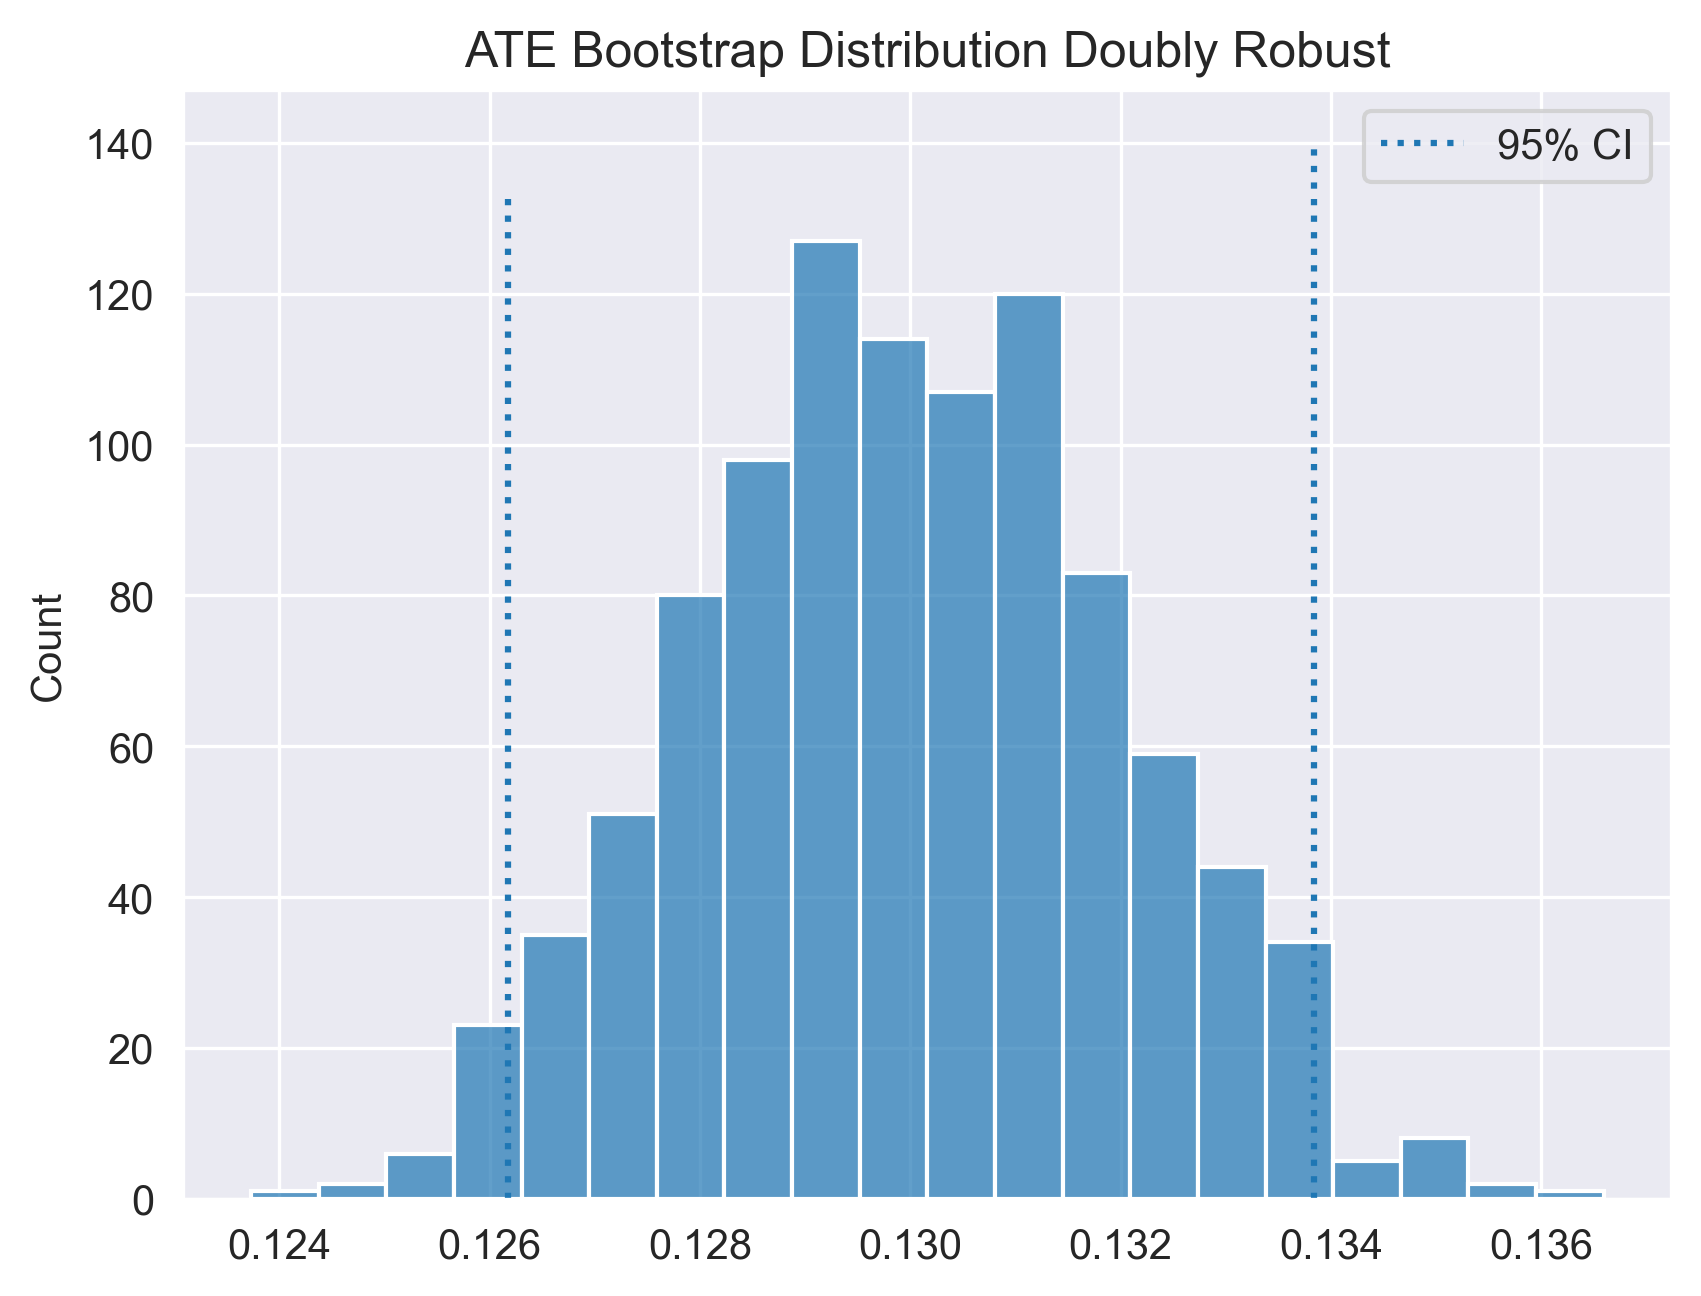

In [69]:
plt.figure(dpi=300)
sns.set_style("darkgrid")

sns.histplot(ates, kde=False, bins=20, alpha=0.7)

plt.vlines(np.percentile(ates, 2.5), 0, plt.gca().get_ylim()[1], linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, plt.gca().get_ylim()[1], linestyles="dotted", label="95% CI")

plt.title("ATE Bootstrap Distribution Doubly Robust")
plt.legend()

plt.show()


#### A/A for doubly robust

In [70]:
def doubly_robust_aa(df_first_error):
    
    categorical_features = []

    numeric_features = [
        "is_login",
        "platform",
        "clicks_notifications",
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numeric_features)
        ])


    ps_model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(penalty="l2", C=100, class_weight="balanced", random_state=42, max_iter=5000))
    ])

    df_first_error = df_first_error[df_first_error["treatment"] == 0]
    n = len(df_first_error[df_first_error["treatment"] == 0])
    
    fake_treatment_indices = np.random.choice(df_first_error[df_first_error["treatment"] == 0].index, n // 2, replace=False)
    df_first_error.loc[fake_treatment_indices, "treatment"] = 1

    treatment = df_first_error["treatment"].values
    outcome = df_first_error["is_order"].values
    X = df_first_error.drop(["treatment", "is_order", "user_id"], axis=1)

    ps_model.fit(X, treatment)
    ps_scores = ps_model.predict_proba(X)[:, 1]

    X_preprocessed = preprocessor.fit_transform(X)

    filter_indices = (ps_scores > 0) & (ps_scores < 1)
    X_filtered = X[filter_indices]
    outcome_filtered = outcome[filter_indices]
    treatment_filtered = treatment[filter_indices]
    ps_scores_filtered = ps_scores[filter_indices]

    X_preprocessed_filtered = preprocessor.fit_transform(X_filtered)

    indices_control_filtered = (treatment_filtered == 0)
    indices_treatment_filtered = (treatment_filtered == 1)

    mu0_model = LinearRegression().fit(X_preprocessed_filtered[indices_control_filtered], outcome_filtered[indices_control_filtered])
    mu1_model = LinearRegression().fit(X_preprocessed_filtered[indices_treatment_filtered], outcome_filtered[indices_treatment_filtered])

    mu0_pred_probs = mu0_model.predict(X_preprocessed_filtered)
    mu1_pred_probs = mu1_model.predict(X_preprocessed_filtered)

    mu0_pred_probs = np.clip(mu0_pred_probs, 0, 1)
    mu1_pred_probs = np.clip(mu1_pred_probs, 0, 1)

    dr_estimate = np.mean(treatment_filtered * (outcome_filtered - mu1_pred_probs) / ps_scores_filtered + mu1_pred_probs) - np.mean((1 - treatment_filtered) * (outcome_filtered - mu0_pred_probs) / (1 - ps_scores_filtered) + mu0_pred_probs)

    return dr_estimate


In [71]:
np.random.seed(41)

bootstrap_sample = 500
ates = Parallel(n_jobs=4)(delayed(doubly_robust_aa)(df_.sample(frac=1, replace=True))
                          for _ in tqdm(range(bootstrap_sample)))
ates = np.array(ates)

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.63it/s]


In [72]:
print(f"A/A ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

A/A ATE 95% CI: (-0.030130141641168857, -0.01768507384462341)


The resulting confidence interval is close to the expected one, but still does not contain 0. In a real situation, this may be a reason to double-check whether we have taken into account all the confounders (since we generated the data, we know that we did not take into account some covariates, but we did this intentionally). In any case, a good result

#### Doubly Robust from EconML

In [73]:
X = df_[["is_login", "platform", "clicks_notifications"]]
T = df_["treatment"]
Y = df_["is_order"]

In [74]:
def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{"alpha": [.001, .01, .1, 1, 10]},
                                               {"max_depth": [3, None],
                                               "min_samples_leaf": [10, 50]},
                                              {"n_estimators": [50, 100],
                                               "max_depth": [3],
                                               "min_samples_leaf": [10, 30]}],
                             cv=5,
                             scoring="neg_mean_squared_error")

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{"C": [0.01, .1, 1, 10, 100]},
                                              {"max_depth": [3, 5],
                                               "min_samples_leaf": [10, 50]},
                                              {"n_estimators": [50, 100],
                                               "max_depth": [3],
                                               "min_samples_leaf": [10, 30]}],
                             cv=5,
                             scoring="neg_mean_squared_error")

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{"alpha": [.001, .01, .1, 1, 10]},
                                              {"max_depth": [3, 5],
                                               "min_samples_leaf": [10, 50]}],
                             cv=5,
                             scoring="neg_mean_squared_error")


In [75]:
model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
model_y

GradientBoostingRegressor(min_samples_leaf=30, random_state=123)

In [76]:
model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
model_t

RandomForestClassifier(max_depth=5, min_samples_leaf=50, random_state=123)

In [77]:
est2 = DRLearner(model_regression=model_y,
                 model_propensity=model_t,
                 model_final=final_stage(),
                 cv=3)
est2.fit(Y, T, X=X)

In [78]:
print(f"ATC estimate: {round(est2.ate(X), 2)}")

ATC estimate: 0.13


### Double Machine Learning

In [79]:
categorical_features = []
numeric_features = [
    "is_login",
    "platform",
    "clicks_notifications",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ])

ps_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

outcome_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

treatment = df_["treatment"].values
outcome = df_["is_order"].values
X = df_.drop(["treatment", "is_order", "user_id"], axis=1)

ps_model.fit(X, treatment)
ps_scores = ps_model.predict_proba(X)[:, 1]

outcome_model.fit(X, outcome)

mu0_pred_probs = outcome_model.predict(X)
mu1_pred_probs = outcome_model.predict(X)


# Correction of residuals
X_preprocessed = preprocessor.fit_transform(X)

filter_indices = (ps_scores > 0) & (ps_scores < 1)
X_filtered = X[filter_indices]
outcome_filtered = outcome[filter_indices]
treatment_filtered = treatment[filter_indices]
ps_scores_filtered = ps_scores[filter_indices]

# We receive residuals
mu0_pred_probs_filtered = mu0_pred_probs[filter_indices]
mu1_pred_probs_filtered = mu1_pred_probs[filter_indices]

# сalculate the residuals for both models
residual_outcome = outcome_filtered - mu0_pred_probs_filtered * (1 - treatment_filtered) \
                        - mu1_pred_probs_filtered * treatment_filtered
residual_treatment = treatment_filtered - ps_scores_filtered

# Estimating ATE using residual data
ate_dml = np.mean(residual_outcome * residual_treatment) / np.mean(residual_treatment ** 2)

print(f"ATE Double Machine Learning: {round(ate_dml, 2)}")


ATE Double Machine Learning: 0.15


#### DML from DoWhy

In [80]:
# model.view_model()

In [81]:
model = CausalModel(
  data=df_,
  treatment="treatment",
  outcome="is_order",
  common_causes=["is_login", "platform", "clicks_notifications"]
)

identified_estimand = model.identify_effect()

In [82]:
dml_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    confidence_intervals=False,
    method_params={
        "init_params":{
           "model_y": GradientBoostingRegressor(),
           "model_t": GradientBoostingRegressor(),
           "model_final": LassoCV(),
           "featurizer": PolynomialFeatures(degree=1, include_bias=True)
        },
        "fit_params": {}
    }
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


In [83]:
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                          
────────────(E[is_order|is_login,clicks_notifications,platform])
d[treatment]                                                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→is_order then P(is_order|treatment,is_login,clicks_notifications,platform,U) = P(is_order|treatment,is_login,clicks_notifications,platform)

## Realized estimand
b: is_order~treatment+is_login+clicks_notifications+platform | 
Target units: ate

## Estimate
Mean value: 0.14999265447598092
Effect estimates: [[0.14999265]]

